# Project: WeRateDogs Twitter data

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling and Cleaning</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

WeRateDogs is a super popular twitter handle that will brighten anyone's day (even if you are a cat lover). In an effort to understand it's popularity, I will analyze information pulled from the twitter API, data produced from an image predition algorithm and twitter archive data. Some questions I am hoping to answer are:

1. What is the relationship between retweet_count and favorite_count?
2. What is the relationship between confidence value and whether the image was identified?
3. Which breed of dogs gets most retweeted?
4. At what time of day do tweets get the most favorites?

<a id='wrangling'></a>
## Data Wrangling and Cleaning

In this section, I'll first read in the necessary files, utilize the Twitter API to pull tweet data. Then I will assess the data to see what cleaning and wrangling needs to occur. Next, I will then list out the quality and tidiness issues and tackle them one by one through defining, coding and testing. The finished product will be a clean "twitter_archive_master.csv" file ready to be analyzed.

In [144]:
import pandas as pd
import numpy as np
import requests
import tweepy
import json
import os
import sys
import datetime
import csv
from timeit import default_timer as timer
import seaborn as sb
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from tweepy import OAuthHandler

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

### Gathering Data
#### Gathering Data from file

In [145]:
twitter_ae = pd.read_csv('twitter-archive-enhanced.csv')

In [146]:
df1 = twitter_ae.copy()

#### Download file from website using Requests

In [147]:
response= requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')

In [148]:
response.status_code

200

In [149]:
response.headers['content-type']

'text/tab-separated-values; charset=utf-8'

In [150]:
with open("image-predictions.tsv", mode = 'wb') as file:
    file.write(response.content)

In [151]:
image_predict = pd.read_csv("image-predictions.tsv", sep = '\t')

In [152]:
df2 = image_predict.copy()

#### Gather data from twitter API using Tweepy library

In [30]:
# Opening Json file
with open('twitter_credentials.json') as cred_data:
    info = json.load(cred_data)
    consumer_key = info['CONSUMER_KEY']
    consumer_secret = info['CONSUMER_SECRET']
    access_key = info['ACCESS_KEY']
    access_secret = info['ACCESS_SECRET']

In [ ]:
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

tweet_ids = twitter_ae.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

In [153]:
df3 = pd.DataFrame(columns=['tweet_id', 'retweet_count', 'favorite_count'])
with open('tweet_json.txt') as f:
    for line in f:
        status  = json.loads(line)
        tweet_id = status['id_str']
        retweet_count = status['retweet_count']
        favorite_count = status['favorite_count']
        df3 = df3.append(pd.DataFrame([[tweet_id, retweet_count, favorite_count]],
                                        columns=['tweet_id', 'retweet_count', 'favorite_count']))
df3 = df3.reset_index(drop=True)

### Assessing Data
#### df1 (Archived)

In [154]:
df1.sample(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1354,703631701117943808,NaN,NaN,2016-02-27 17:24:05 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bella. Based on this picture she's at ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/703631701...,11,10,Bella,None,None,None,None
1046,743545585370791937,NaN,NaN,2016-06-16 20:47:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Bentley and Millie. They do every...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/743545585...,11,10,Bentley,None,None,None,None
408,823581115634085888,NaN,NaN,2017-01-23 17:20:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Crawford. He's quite h*ckin good at th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/823581115...,11,10,Crawford,None,None,None,None


In [155]:
df1.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [156]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [157]:
df1.timestamp.min()

'2015-11-15 22:32:08 +0000'

In [158]:
df1.timestamp.max()

'2017-08-01 16:23:56 +0000'

In [159]:
df1.expanded_urls.isnull().sum()

59

In [160]:
len(df1.query("name == 'None'"))

745

In [161]:
df1.name.value_counts()

None            745
a                55
Charlie          12
Cooper           11
Lucy             11
Oliver           11
Tucker           10
Lola             10
Penny            10
Winston           9
Bo                9
the               8
Sadie             8
Bailey            7
Toby              7
an                7
Buddy             7
Daisy             7
Dave              6
Stanley           6
Jack              6
Leo               6
Koda              6
Jax               6
Scout             6
Rusty             6
Bella             6
Oscar             6
Milo              6
Bentley           5
               ... 
Kara              1
Comet             1
Tanner            1
Arya              1
Dante             1
Winifred          1
Harry             1
Blu               1
Kathmandu         1
Ralph             1
Linus             1
Shiloh            1
Timmy             1
Lucky             1
Tayzie            1
Alexanderson      1
Oddie             1
Smiley            1
Sailer            1


#### df2 (Image predictions)

In [162]:
df2.sample(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1917,854732716440526848,https://pbs.twimg.com/media/C9ye3b3WAAAlTo0.jpg,1,Pembroke,0.695548,True,Cardigan,0.058902,True,chow,0.028411,True
1863,842846295480000512,https://pbs.twimg.com/media/C7JkO0rX0AErh7X.jpg,1,Labrador_retriever,0.461076,True,golden_retriever,0.154946,True,Chihuahua,0.110249,True
1563,793601777308463104,https://pbs.twimg.com/media/CwNwmxvXEAEJ54Z.jpg,1,miniature_pinscher,0.538981,True,Chihuahua,0.217830,True,toy_terrier,0.089149,True


In [163]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [164]:
df2.tweet_id.nunique()

2075

In [165]:
df2.img_num.value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

#### df3 (Twitter API)

In [166]:
df3.sample(3)

,tweet_id,retweet_count,favorite_count
640,791784077045166082,10403,0
2209,668256321989451776,621,1307
1297,706681918348251136,1018,3438


In [167]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 3 columns):
tweet_id          2337 non-null object
retweet_count     2337 non-null object
favorite_count    2337 non-null object
dtypes: object(3)
memory usage: 54.9+ KB


### Quality
df1 (Archive):
1. We want only the original tweets and no retweets. The columns 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'in_reply_to_user_id'and 'in_reply_to_status_id' are not useful after we get rid of retweets.
2. Some expanded_urls are missing.
3. 'twitter_id' is wrong datatype. 
4. 'Timestamp' is the wrong datatype.

df2 (Image Predictions):
1. 'twitter_id' is wrong datatype. 
2. 'p1', 'p2' and 'p3' are not consistently capitalized.
3. 'p1', 'p2', and 'p3' have some predictions that are not dogs. p1, p1_dog, p2, p2_dog, p3, p3_dog column headers are confusing.
4. The column 'img_num' is not useful.

df3 (Twitter API)
1. 'retweet_count', and 'favorite_count' are wrong datatypes.

### Tidiness
df1 (Archive):
1. The columns 'doggo', 'floofer', 'pupper','puppo' are in 4 different columns when they describe one variable- the various stages of dog. 

All three files can be merged into one since they are the same observational unit.
 

### Quality

### df1 (Archived)

#### Define:

We want only the original tweets and no retweets. If 'retweeted_status_user_id' and/or 'in_reply_to_user_id' isnull that means the tweet was not used as a retweet. Identify the tweets that are null using isnull function and save them in a new version of df1.

#### Code:

In [168]:
df1 = df1[df1.retweeted_status_user_id.isnull()]
df1 = df1[df1.in_reply_to_user_id.isnull()]

#### Test:

In [169]:
sum(df1.in_reply_to_user_id.notnull())

0

In [170]:
sum(df1.retweeted_status_user_id.notnull())

0

#### Define: 

The columns 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'in_reply_to_user_id'and 'in_reply_to_status_id' are not useful after retweets were deleted. Use drop function to delete.

#### Code:

In [171]:
df1=df1.drop(['retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp','in_reply_to_user_id','in_reply_to_status_id'],axis=1)

#### Test:

In [172]:
list(df1)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

#### Define:

Expanded_urls has 3 null values. Delete them using notnull function.

#### Code:

In [173]:
df1 = df1[df1.expanded_urls.notnull()]

#### Test:

In [174]:
sum(df1.expanded_urls.isnull())

0

#### Define:

'twitter_id' is wrong datatype. It's int64 and should be a string. Use astype to convert.

#### Code:

In [175]:
df1.tweet_id = df1.tweet_id.astype(str)

#### Test:

In [176]:
df1.tweet_id.dtypes

dtype('O')

#### Define:

'Timestamp' is type object and should be type Timestamp

#### Code:

In [177]:
df1.timestamp=pd.to_datetime(df1.timestamp)

#### Test:

In [178]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2094 non-null object
timestamp             2094 non-null datetime64[ns]
source                2094 non-null object
text                  2094 non-null object
expanded_urls         2094 non-null object
rating_numerator      2094 non-null int64
rating_denominator    2094 non-null int64
name                  2094 non-null object
doggo                 2094 non-null object
floofer               2094 non-null object
pupper                2094 non-null object
puppo                 2094 non-null object
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 212.7+ KB


### df2 (Image Predictions):

#### Define:
'twitter_id' is wrong datatype. It's int64 and should be a string. Use astype to convert.

#### Code:

In [179]:
df2.tweet_id = df2.tweet_id.astype(str)

#### Test:

In [180]:
df2.tweet_id.dtypes

dtype('O')

#### Define:
p1, p2 and p3 predictions for the type of dog are not all capitalized. Utilize the str and capitalize function to capitalize the first letter.

#### Code:

In [181]:
df2.p1 = df2.p1.str.capitalize()

In [182]:
df2.p2 = df2.p2.str.capitalize()

In [183]:
df2.p3 = df2.p3.str.capitalize()

#### Test:

In [184]:
df2.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1314,754856583969079297,https://pbs.twimg.com/media/CnnKCKNWgAAcOB8.jpg,2,Golden_retriever,0.872385,True,Labrador_retriever,0.099963,True,Cocker_spaniel,0.006051,True
926,702598099714314240,https://pbs.twimg.com/media/CcAhPevW8AAoknv.jpg,1,Kelpie,0.219179,True,Badger,0.133584,False,Siamese_cat,0.074440,False
1048,713411074226274305,https://pbs.twimg.com/media/CeaLlAPUMAIcC7U.jpg,1,Great_pyrenees,0.720337,True,Samoyed,0.129542,True,Kuvasz,0.122451,True
1955,864279568663928832,https://pbs.twimg.com/media/C_6JrWZVwAAHhCD.jpg,1,Bull_mastiff,0.668613,True,French_bulldog,0.180562,True,Staffordshire_bullterrier,0.052237,True
484,675483430902214656,https://pbs.twimg.com/media/CV_MmGZU8AAggM6.jpg,1,Box_turtle,0.543706,False,Terrapin,0.202600,False,Loggerhead,0.071122,False


#### Define:

p1, p2 and p3 are not all dog breeds per p1_dog, p2_dog, p3_dog. If p1_dog is False, replace p1 with Breed_not_identified.

#### Code:

In [185]:
df2.p1[df2.p1_dog==False]='Breed_not_identified'

In [186]:
df2.p2[df2.p2_dog==False]='Breed_not_identified'

In [187]:
df2.p3[df2.p3_dog==False]='Breed_not_identified'

#### Test:

In [188]:
df2.p1.value_counts()

Breed_not_identified           543
Golden_retriever               150
Labrador_retriever             100
Pembroke                        89
Chihuahua                       83
Pug                             57
Chow                            44
Samoyed                         43
Toy_poodle                      39
Pomeranian                      38
Malamute                        30
Cocker_spaniel                  30
French_bulldog                  26
Chesapeake_bay_retriever        23
Miniature_pinscher              23
German_shepherd                 20
Staffordshire_bullterrier       20
Siberian_husky                  20
Cardigan                        19
Maltese_dog                     18
Eskimo_dog                      18
Beagle                          18
Shetland_sheepdog               18
Lakeland_terrier                17
Rottweiler                      17
Shih-tzu                        17
Italian_greyhound               16
Kuvasz                          16
West_highland_white_

In [189]:
df2.p2.value_counts()

Breed_not_identified              522
Labrador_retriever                104
Golden_retriever                   92
Cardigan                           73
Chihuahua                          44
Pomeranian                         42
Chesapeake_bay_retriever           41
French_bulldog                     41
Toy_poodle                         37
Cocker_spaniel                     34
Miniature_poodle                   33
Siberian_husky                     33
Beagle                             28
Collie                             27
Pembroke                           27
Eskimo_dog                         27
Kuvasz                             26
Italian_greyhound                  22
Pekinese                           21
American_staffordshire_terrier     21
Samoyed                            20
Miniature_pinscher                 20
Chow                               20
Malinois                           20
Toy_terrier                        20
Norwegian_elkhound                 19
Boston_bull 

In [190]:
df2.p3.value_counts()

Breed_not_identified              576
Labrador_retriever                 79
Chihuahua                          58
Golden_retriever                   48
Eskimo_dog                         38
Kelpie                             35
Kuvasz                             34
Staffordshire_bullterrier          32
Chow                               32
Cocker_spaniel                     31
Beagle                             31
Pomeranian                         29
Toy_poodle                         29
Pekinese                           29
Pembroke                           27
Chesapeake_bay_retriever           27
Great_pyrenees                     27
Malamute                           26
French_bulldog                     26
American_staffordshire_terrier     24
Pug                                23
Cardigan                           23
Basenji                            21
Bull_mastiff                       20
Toy_terrier                        20
Siberian_husky                     19
Boston_bull 

#### Test:

In [191]:
df2.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1423,772117678702071809,https://pbs.twimg.com/media/Crcc7pqXEAAM5O2.jpg,1,Labrador_retriever,0.217821,True,Beagle,0.157677,True,Golden_retriever,0.127726,True
146,668627278264475648,https://pbs.twimg.com/media/CUdw9thWsAA4mB9.jpg,1,French_bulldog,0.965403,True,Pug,0.008604,True,Boston_bull,0.008004,True
1490,782722598790725632,https://pbs.twimg.com/media/CtzKC7zXEAALfSo.jpg,1,Irish_setter,0.574557,True,Golden_retriever,0.339251,True,Breed_not_identified,0.046108,False
1886,847962785489326080,https://pbs.twimg.com/media/C8SRpHNUIAARB3j.jpg,1,Breed_not_identified,0.882654,False,Breed_not_identified,0.066880,False,Breed_not_identified,0.025679,False
1358,760656994973933572,https://pbs.twimg.com/media/Co5lf-KW8AAIwJw.jpg,1,Golden_retriever,0.760546,True,Labrador_retriever,0.232079,True,Redbone,0.002874,True


#### Define:

p1, p1_dog, p2, p2_dog, p3, p3_dog column headers are confusing. p1_dog, p2_dog, and p3_dog are not needed anymore since "Breed_not_identified" was written in p1,p2,p3 if the value was False. 

Utilize the drop fuction to delete p1_dog, p2_dog, p3_dog.

Label column header for p1 to be algo1_predicted_breed, p2 as algo2_predicted_breed, p3 as algo3_predicted_breed. 

Rename p1_conf, p2_conf and p3_conf as algo1_conf, algo2_conf, algo3_conf.

#### Code:

In [192]:
df2 = df2.drop(['p1_dog', 'p2_dog', 'p3_dog'], axis = 1)

In [193]:
df2.rename(columns = {"p1" : "algo1_predicted_breed", 
                      "p2" : "algo2_predicted_breed",
                      "p3" : "algo3_predicted_breed",
                      "p1_conf" : "algo1_conf",
                      "p2_conf" : "algo2_conf",
                      "p3_conf" : "algo3_conf"}, inplace = True)

#### Test:

In [194]:
df2.sample(5)

,tweet_id,jpg_url,img_num,algo1_predicted_breed,algo1_conf,algo2_predicted_breed,algo2_conf,algo3_predicted_breed,algo3_conf
774,689623661272240129,https://pbs.twimg.com/media/CZIJD2SWIAMJgNI.jpg,1,Toy_poodle,0.279604,Breed_not_identified,0.208564,Labrador_retriever,0.077481
1482,781163403222056960,https://pbs.twimg.com/media/Ctc_-BTWEAAQpZh.jpg,1,Shetland_sheepdog,0.973841,Collie,0.025188,Border_collie,0.000297
1127,727644517743104000,https://pbs.twimg.com/media/Chkc1BQUoAAa96R.jpg,2,Great_pyrenees,0.457164,Kuvasz,0.391710,Labrador_retriever,0.094523
375,672997845381865473,https://pbs.twimg.com/media/CVb39_1XIAAMoIv.jpg,1,Chow,0.517255,Pomeranian,0.206053,Breed_not_identified,0.127037
1683,813944609378369540,https://pbs.twimg.com/media/Cveg1-NXgAASaaT.jpg,1,Labrador_retriever,0.427742,Great_dane,0.190503,Curly-coated_retriever,0.146427


#### Define:
The column 'img_num' is not useful. Delete it using drop function

#### Code:

In [195]:
df2 = df2.drop(['img_num'], axis = 1)

#### Test:

In [196]:
list(df2)

['tweet_id',
 'jpg_url',
 'algo1_predicted_breed',
 'algo1_conf',
 'algo2_predicted_breed',
 'algo2_conf',
 'algo3_predicted_breed',
 'algo3_conf']

### df3 (Twitter API):

#### Define:
'retweet_count', and 'favorite_count' are wrong datatypes. Should be int64. Use astype to convert.

#### Code:

In [197]:
df3.retweet_count = df3.retweet_count.astype('int64')

In [198]:
df3.favorite_count = df3.favorite_count.astype('int64')

#### Test:

In [199]:
df3.retweet_count.dtypes

dtype('int64')

In [200]:
df3.favorite_count.dtypes

dtype('int64')

## Tidiness

### df1 (Archive):
#### Define:

The columns 'doggo', 'floofer', 'pupper','puppo' show one variable, but are in 4 separate columns. Replace 'None' with ' ' and use the concat function to string the 4 columns together. Delete dogs that have multiple stages by detecting if the string is longer than 7 characters. Change '' back to 'None'. 

#### Code:

In [201]:
df1.doggo = df1.doggo.replace('None', '')
df1.floofer = df1.floofer.replace('None', '')
df1.pupper = df1.pupper.replace('None', '')
df1.puppo = df1.puppo.replace('None', '')

In [202]:
df1.doggo.value_counts()

         2011
doggo      83
Name: doggo, dtype: int64

In [203]:
df1['dog_stage']=df1.doggo.str.cat(df1.floofer).str.cat(df1.pupper).str.cat(df1.puppo)

In [204]:
df1.dog_stage.value_counts()

                1759
pupper           220
doggo             72
puppo             23
doggopupper        9
floofer            9
doggopuppo         1
doggofloofer       1
Name: dog_stage, dtype: int64

In [205]:
df1.loc[df1['dog_stage'].str.len() > 8 , 'dog_stage'] = "multiple"

In [206]:
df1.dog_stage = df1.dog_stage.replace('', "None")

In [207]:
df1 = df1.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis = 1)

#### Test:

In [208]:
df1.dog_stage.value_counts()

None        1759
pupper       220
doggo         72
puppo         23
multiple      11
floofer        9
Name: dog_stage, dtype: int64

In [209]:
df1.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
1193,717537687239008257,2016-04-06 02:21:30,"<a href=""http://twitter.com/download/iphone"" r...",People please. This is a Deadly Mediterranean ...,https://twitter.com/dog_rates/status/717537687...,11,10,a,None
712,784431430411685888,2016-10-07 16:33:21,"<a href=""http://twitter.com/download/iphone"" r...",This is Stormy. He's curly af. Already pupared...,https://twitter.com/dog_rates/status/784431430...,12,10,Stormy,None
1807,676916996760600576,2015-12-16 00:09:23,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",Super speedy pupper. Does not go gentle into t...,https://vine.co/v/imJ0BdZOJTw,10,10,None,pupper
229,848212111729840128,2017-04-01 16:35:01,"<a href=""http://twitter.com/download/iphone"" r...",This is Jerry. He's doing a distinguished tong...,https://twitter.com/dog_rates/status/848212111...,6,10,Jerry,None
1078,739485634323156992,2016-06-05 15:54:48,"<a href=""http://twitter.com/download/iphone"" r...",This is Kyle. He's a heavy drinker and an avid...,https://twitter.com/dog_rates/status/739485634...,6,10,Kyle,None


#### Define:

All three files can be merged into one utilizing 'tweet_id' and merge function.

#### Code:

In [210]:
df_merged = df1.merge(df2,on='tweet_id').merge(df3,on='tweet_id')

#### Test:

In [211]:
df_merged.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,jpg_url,algo1_predicted_breed,algo1_conf,algo2_predicted_breed,algo2_conf,algo3_predicted_breed,algo3_conf,retweet_count,favorite_count
453,793500921481273345,2016-11-01 17:12:16,"<a href=""http://twitter.com/download/iphone"" r...",This is Fiona. She's an extremely mediocre cop...,https://twitter.com/dog_rates/status/793500921...,12,10,Fiona,None,https://pbs.twimg.com/media/CwMU34YWIAAz1nU.jpg,Golden_retriever,0.326122,Labrador_retriever,0.219904,Chesapeake_bay_retriever,0.163366,2571,11317
1414,677918531514703872,2015-12-18 18:29:07,"<a href=""http://twitter.com/download/iphone"" r...","""Everything looks pretty good in there. Make s...",https://twitter.com/dog_rates/status/677918531...,10,10,None,None,https://pbs.twimg.com/media/CWhzTbzWUAAEAUN.jpg,Eskimo_dog,0.199347,Dalmatian,0.153225,American_staffordshire_terrier,0.107798,430,1385
1023,705970349788291072,2016-03-05 04:17:02,"<a href=""http://twitter.com/download/iphone"" r...",This is Lucy. She's a Venetian Kerploof. Suppo...,https://twitter.com/dog_rates/status/705970349...,12,10,Lucy,None,https://pbs.twimg.com/media/CcwcSS9WwAALE4f.jpg,Golden_retriever,0.776346,Labrador_retriever,0.112413,Chow,0.036953,928,3243
1777,669567591774625800,2015-11-25 17:25:28,"<a href=""http://twitter.com/download/iphone"" r...",Meet Kollin. He's a Parakeetian Badminton from...,https://twitter.com/dog_rates/status/669567591...,9,10,Kollin,None,https://pbs.twimg.com/media/CUrIK1DWoAAhECq.jpg,Chihuahua,0.980511,Toy_terrier,0.009166,Miniature_pinscher,0.002659,55,235
1061,701981390485725185,2016-02-23 04:06:20,"<a href=""http://twitter.com/download/iphone"" r...",This is Fiji. She's a Powdered Stegafloof. Ver...,https://twitter.com/dog_rates/status/701981390...,12,10,Fiji,None,https://pbs.twimg.com/media/Cb3wWWbWEAAy06k.jpg,Pomeranian,0.491022,Breed_not_identified,0.130879,Yorkshire_terrier,0.099241,1039,3567


In [212]:
#Store final data frame in twitter_archive_master
twitter_archive_master = df_merged.copy()

In [213]:
twitter_archive_master.to_csv('twitter_archive_master.csv', encoding='utf-8', index=False)

In [214]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1967 entries, 0 to 1966
Data columns (total 18 columns):
tweet_id                 1967 non-null object
timestamp                1967 non-null datetime64[ns]
source                   1967 non-null object
text                     1967 non-null object
expanded_urls            1967 non-null object
rating_numerator         1967 non-null int64
rating_denominator       1967 non-null int64
name                     1967 non-null object
dog_stage                1967 non-null object
jpg_url                  1967 non-null object
algo1_predicted_breed    1967 non-null object
algo1_conf               1967 non-null float64
algo2_predicted_breed    1967 non-null object
algo2_conf               1967 non-null float64
algo3_predicted_breed    1967 non-null object
algo3_conf               1967 non-null float64
retweet_count            1967 non-null int64
favorite_count           1967 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(4), object(10

<a id='eda'></a>
## Exploratory Data Analysis

Now that we have a clean dataframe to work with, let's start analyzing.

Questions to answer:

1. What is the relationship between retweet_count and favorite_count?
2. What is the relationship between confidence value and whether the image was identified as a dog? Which algorithm appears to be the best?
3. Which breed of dogs gets most retweeted?
4. At what time of day do tweets get the most favorites?


#### Retweets and Favorites

Let's look at the relationship between retweet count and favorite count with a scatter plot.

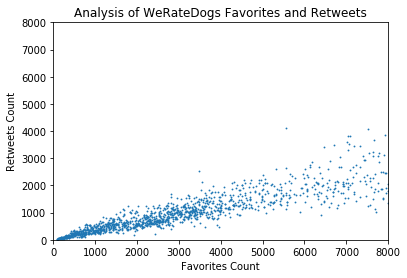

In [215]:
# Scatter plot of favorites and retweets.
plt.xlim(0, 8000)
plt.ylim(0, 8000)
plt.scatter(data = twitter_archive_master, x = 'favorite_count', y = 'retweet_count', s = 0.7)
plt.title('Analysis of WeRateDogs Favorites and Retweets');
plt.xlabel('Favorites Count');
plt.ylabel('Retweets Count');

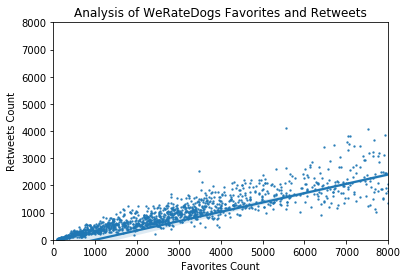

In [216]:
plt.xlim(0, 8000);
plt.ylim(0, 8000);
sb.regplot(data = twitter_archive_master, x = 'favorite_count', y = 'retweet_count', scatter_kws={'s':2})
plt.title('Analysis of WeRateDogs Favorites and Retweets');
plt.xlabel('Favorites Count');
plt.ylabel('Retweets Count');

There's a linear and upward trending relationship between favorites and retweets, which is to be expected. What does log 10 graph look like.

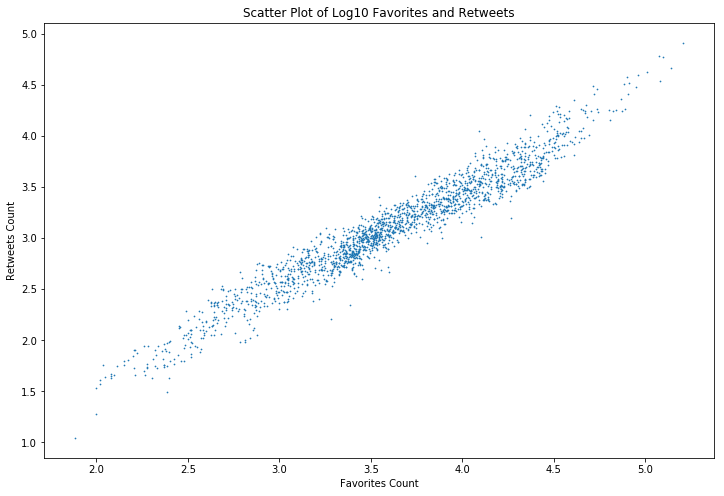

In [217]:
# Log10 scatter plot of favorites and retweets.
plt.figure(figsize=(12, 8))
plt.xlabel('Favorites Count')
plt.ylabel('Retweets Count')
plt.plot(np.log10(twitter_archive_master.favorite_count), np.log10(twitter_archive_master.retweet_count), 
           linestyle='', marker='o', markersize=0.7)
plt.title('Scatter Plot of Log10 Favorites and Retweets');

But what is the relationship between the two variables. Let's run a regression to find out.

In [218]:
twitter_archive_master['intercept']=1
lm=sm.OLS(twitter_archive_master['favorite_count'],twitter_archive_master[['intercept','retweet_count']])
results= lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         favorite_count   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                 1.251e+04
Date:                Thu, 30 May 2019   Prob (F-statistic):               0.00
Time:                        01:59:22   Log-Likelihood:                -19408.
No. Observations:                1967   AIC:                         3.882e+04
Df Residuals:                    1965   BIC:                         3.883e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept      2039.5165    120.652     16.904      0.000    1802.897    2276.136
retweet_count     2.5177      0.023    111.860      0.000       2.474       2.562
==============================================================================
Omnibus:                      521.195   Durbin-Watson:                   0.767
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16551.015
Skew:                           0.580   Prob(JB):                         0.00
Kurtosis:                      17.163   Cond. No.                     6.15e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.15e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

For every 2.5 favorites, a WeRateDogs tweet will be retweeted.

#### Confidence Intervals and Breed Identification

One of the data sets ran the WeRateDogs Twitter archive through a neural netwrok that can classify breeds of dogs. p1 is the algorithm's first prediction, p2 is the algorithm's second prediction, and so on. 

Let's look at the histogram of confidence levels for the algorithm's first prediction.

In [219]:
a = len(twitter_archive_master.query("algo1_predicted_breed =='Breed_not_identified'"))/len(twitter_archive_master)

In [220]:
b = len(twitter_archive_master.query("algo2_predicted_breed =='Breed_not_identified'"))/len(twitter_archive_master)

In [221]:
c = len(twitter_archive_master.query("algo3_predicted_breed =='Breed_not_identified'"))/len(twitter_archive_master)

In [222]:
tmp = {'Prediction number': ['1st Prediction', '2nd Prediction', '3rd Prediction'], 'Percentage that is Actually a Dog Breed': [a,b,c]}
tmp = pd.DataFrame(data=tmp)
tmp

,Prediction number,Percentage that is Actually a Dog Breed
0,1st Prediction,0.258261
1,2nd Prediction,0.249619
2,3rd Prediction,0.274530


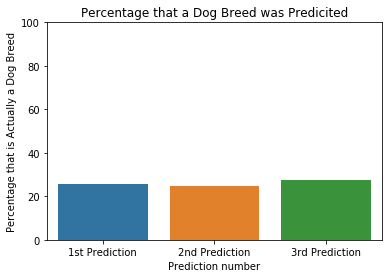

In [223]:
ax = sb.barplot(data = tmp, x = tmp['Prediction number'], y = tmp["Percentage that is Actually a Dog Breed"]*100)
plt.ylim(0, 100);
plt.title('Percentage that a Dog Breed was Predicited');

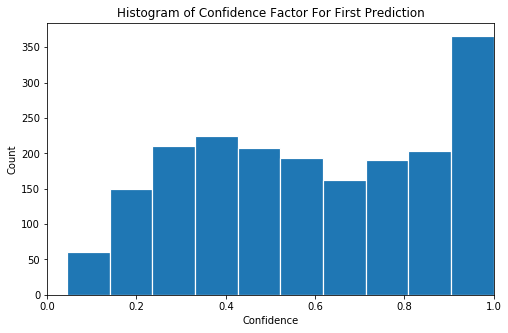

In [224]:
plt.figure(figsize=(8, 5))
plt.xlim(0, 1)
plt.xlabel('Confidence')
plt.ylabel('Count')
plt.hist(x = twitter_archive_master.algo1_conf, 
    edgecolor='white', linewidth=1.2)
plt.title('Histogram of Confidence Factor For First Prediction');

This chart shows all confidence intervals, including whether the image prediction was actually a breed of dog or not.

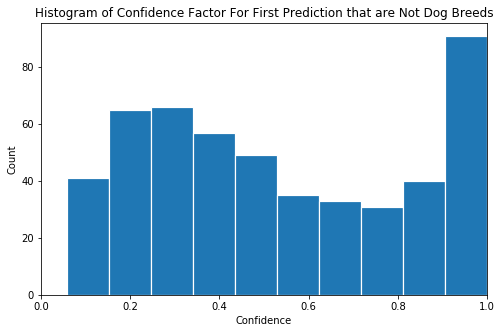

In [225]:
plt.figure(figsize=(8, 5))
plt.xlim(0, 1)
plt.xlabel('Confidence')
plt.ylabel('Count')
plt.hist(x = twitter_archive_master.query("algo1_predicted_breed =='Breed_not_identified'").algo1_conf, 
    edgecolor='white', linewidth=1.2)
plt.title('Histogram of Confidence Factor For First Prediction that are Not Dog Breeds');

Predictions that are not breeds generally follow the same curve as those that are. It's interesting to see there is a spike at .9-1.0 when the image has definitively been misidentified. It could be the case that an image had a "ball" or some other object in it and that was identified.

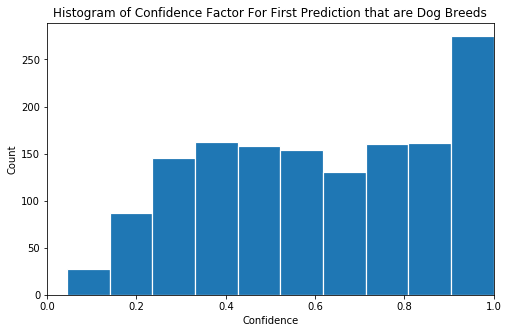

In [226]:
plt.figure(figsize=(8, 5))
plt.xlim(0, 1)
plt.xlabel('Confidence')
plt.ylabel('Count')
plt.hist(x = twitter_archive_master.query("algo1_predicted_breed !='Breed_not_identified'").algo1_conf, 
    edgecolor='white', linewidth=1.2)
plt.title('Histogram of Confidence Factor For First Prediction that are Dog Breeds');

Overlay of images that were predicted as breeds and as something else

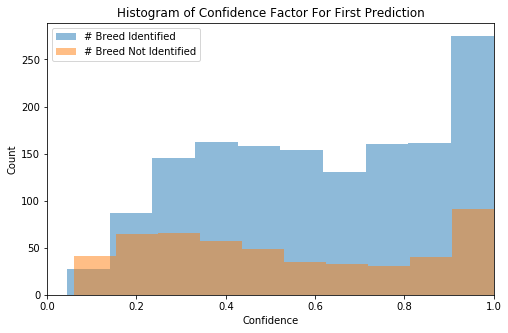

In [227]:
plt.figure(figsize=(8, 5))
plt.xlim(0, 1)
plt.xlabel('Confidence')
plt.ylabel('Count')
plt.hist(x = twitter_archive_master.query("algo1_predicted_breed!='Breed_not_identified'").algo1_conf, 
    alpha=.5, label='# Breed Identified')
plt.hist(x = twitter_archive_master.query("algo1_predicted_breed=='Breed_not_identified'").algo1_conf, 
    alpha=.5, label='# Breed Not Identified')
plt.title('Histogram of Confidence Factor For First Prediction');
plt.legend();

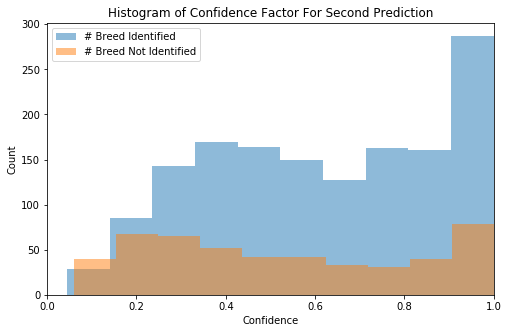

In [228]:
plt.figure(figsize=(8, 5))
plt.xlim(0, 1)
plt.xlabel('Confidence')
plt.ylabel('Count')
plt.hist(x = twitter_archive_master.query("algo2_predicted_breed!='Breed_not_identified'").algo1_conf, 
    alpha=.5, label='# Breed Identified')
plt.hist(x = twitter_archive_master.query("algo2_predicted_breed=='Breed_not_identified'").algo1_conf, 
    alpha=.5, label='# Breed Not Identified')
plt.title('Histogram of Confidence Factor For Second Prediction');
plt.legend();

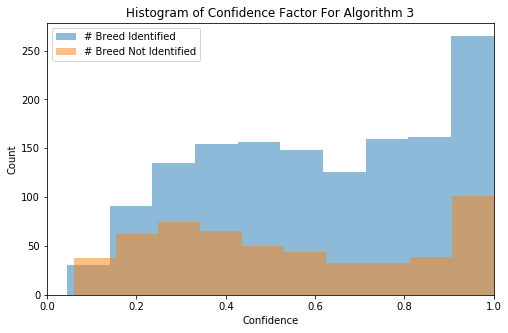

In [229]:
plt.figure(figsize=(8, 5))
plt.xlim(0, 1)
plt.xlabel('Confidence')
plt.ylabel('Count')
plt.hist(x = twitter_archive_master.query("algo3_predicted_breed!='Breed_not_identified'").algo1_conf, 
    alpha=.5, label='# Breed Identified')
plt.hist(x = twitter_archive_master.query("algo3_predicted_breed=='Breed_not_identified'").algo1_conf, 
    alpha=.5, label='# Breed Not Identified')
plt.title('Histogram of Confidence Factor For Algorithm 3');
plt.legend();

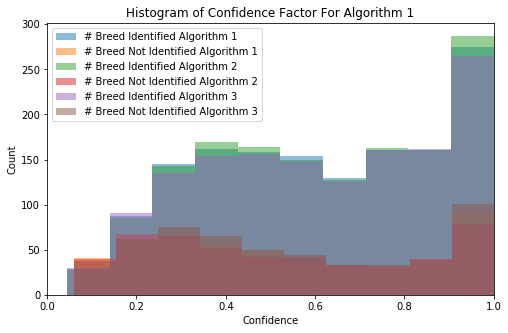

In [230]:
plt.figure(figsize=(8, 5))
plt.xlim(0, 1)
plt.xlabel('Confidence')
plt.ylabel('Count')
plt.hist(x = twitter_archive_master.query("algo1_predicted_breed!='Breed_not_identified'").algo1_conf, 
    alpha=.5, label='# Breed Identified Algorithm 1')
plt.hist(x = twitter_archive_master.query("algo1_predicted_breed=='Breed_not_identified'").algo1_conf, 
    alpha=.5, label='# Breed Not Identified Algorithm 1')
plt.hist(x = twitter_archive_master.query("algo2_predicted_breed!='Breed_not_identified'").algo1_conf, 
    alpha=.5, label='# Breed Identified Algorithm 2')
plt.hist(x = twitter_archive_master.query("algo2_predicted_breed=='Breed_not_identified'").algo1_conf, 
    alpha=.5, label='# Breed Not Identified Algorithm 2')
plt.hist(x = twitter_archive_master.query("algo3_predicted_breed!='Breed_not_identified'").algo1_conf, 
    alpha=.5, label='# Breed Identified Algorithm 3')
plt.hist(x = twitter_archive_master.query("algo3_predicted_breed=='Breed_not_identified'").algo1_conf, 
    alpha=.5, label='# Breed Not Identified Algorithm 3')
plt.title('Histogram of Confidence Factor For Algorithm 1');
plt.legend();

The shapes are generally the same for any of the predictions

#### Which breed of dog is most retweeted?

In [231]:
breed_retweeted = twitter_archive_master[
    twitter_archive_master.algo1_predicted_breed != 'Breed_not_identified']
breed_retweeted = breed_retweeted.groupby(
    'algo1_predicted_breed').sum().reset_index()
breed_retweeted = breed_retweeted[[
    'algo1_predicted_breed', 'retweet_count']]
breed_retweeted = breed_retweeted.sort_values(
    'retweet_count', ascending = False)[0:10]
breed_retweeted

,algo1_predicted_breed,retweet_count
44,Golden_retriever,471651
60,Labrador_retriever,329728
78,Pembroke,262737
26,Chihuahua,211564
86,Samoyed,163525
40,French_bulldog,113394
27,Chow,110621
79,Pomeranian,101220
29,Cocker_spaniel,93390
38,Eskimo_dog,91872


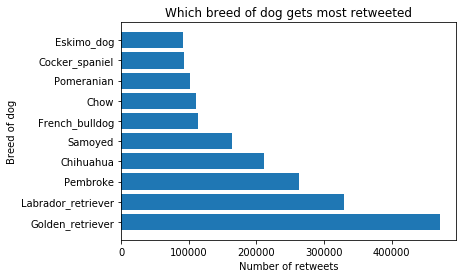

In [232]:
plt.barh(breed_retweeted.algo1_predicted_breed, breed_retweeted.retweet_count);
plt.ylabel('Breed of dog');
plt.xlabel('Number of retweets');
plt.title('Which breed of dog gets most retweeted');

Keep in mind, the breed is not actually confirmed with the image, it's just been confirmed that the prediction was a breed of dog. Interesting that retrievers are the top retweet with goldens leading the pack.

#### At what time does a tweet get the most favorites?

In [233]:
tmp = twitter_archive_master[["timestamp","favorite_count"]]

In [234]:
tmp["hour"] = tmp.timestamp.dt.hour

In [235]:
array=tmp.groupby('hour')['favorite_count'].sum()

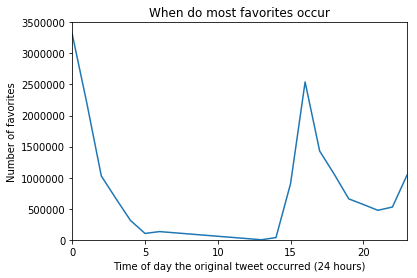

In [236]:
plt.plot(tmp.groupby('hour')['favorite_count'].sum());
plt.xlabel('Time of day the original tweet occurred (24 hours)');
plt.ylabel('Number of favorites');
plt.title('When do most favorites occur');
plt.xlim(0, 23);
plt.ylim(0, 3500000);

A tweet written at midnight gets the most favorites. The next spike is around 4pm. However, it's not easy to interpret the timestamp. From the twitter developer page, timestamp is recorded in UTC (Greenwich) which is the time in London. This is 6 hours ahead of the Central Time Zone. The peak time occurred at midnight (or 6pm CST) and 4pm (10am CST). I decided to leave this in UTC because I travel quite often and it's easier to convert from that timezone. This data does not tell us when the favorite occurred. 

<a id='conclusions'></a>
## Conclusions

On average there is 2.5 favorites for every retweet.

The image prediction was not very accurate. It only identified a dog breed 25% of the time. The confidence interval histogram was the same shape whether a dog breed was identified or not (though at a lower count).

Golden retrievers were the most retweeted dog followed by laborador retrievers.

A tweet written at midnight (UTC) gets the most favorites. The next spike is around 4pm.


### Limitations

One of the biggest issues with the image identification is that we don't have a confirmation whether or not the predicted breed actually matched the dog pictured. It's concerning that some of the predictions that were not dog breeds, but other objects had a high confidence level of above 0.9. There is a chance that the non-dog object was actually in the image (a ball, paper towel, etc) but one would have expected that the histogram of confidence be more right skewed.

Another issue is with the timezone. The data does not tell us when the favorite occurred, only when the tweet was first published. If WeRateDogs is wanting the chance for the most favorites, they would need to convert the 00:00 and 16:00 to their current timezone. It would be interesting to see the amount of favorites and retweets of all twitter handles at that time had the same trend as WeRateDogs.